In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time

In [2]:
#import data to matrix following information from yeast.names
Data = pd.read_fwf("yeast.data", delim_whitespace=True, 
                     names=["name", "id", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc"])
print(Data['name'])
#converts my data into an array shuffles and converts back to dataframe
arr = Data.values
arr = shuffle(arr, random_state=0)
Data = pd.DataFrame(arr, index=Data.index, columns=Data.columns)
#Splits my data into a training and a testing set
ttrain, truetest = train_test_split(Data, test_size=0.2, random_state=0)
print(len(Data))

0       ADT1_YEAST
1       ADT2_YEAST
2       ADT3_YEAST
3       AAR2_YEAST
4       AATM_YEAST
           ...    
1479    YUR1_YEAST
1480    ZIP1_YEAST
1481    ZNRP_YEAST
1482    ZUO1_YEAST
1483    G6PD_YEAST
Name: name, Length: 1484, dtype: object
1484


In [3]:
def euclideanDist(pointA, pointB, elementWeights):
    d = 0.0
    for i in range(1,9):
        d += elementWeights[i-1]*((float(pointA[i])-float(pointB[i]))**2)
    d = np.sqrt(d)
    return d
    #for each dimenstion(attributes 2-8 inclusive) in A and B square the difference
    #multiply that squared distance by the corresponding weight
    #finally take the square root of the sum of those values and return it

In [4]:
def vote(nn):
    #given a tuple where the second element is a list of labels to the nearest kluster centers
    #this method will find the label of the nearest cluster center for the majority of the list
    #and return that label for assignment
    temp = [n[1] for n in nn]
    counts = [temp.count(t) for t in temp]
    return temp[counts.index(max(counts))]

In [5]:
def helper(data, targets, weights):
    #tictoc helps us determine how long our code has been running (used for debugging)
    tictoc = time.time()
    #because it is time consuming to create a new dictionary/map each iteration
    #this function takes each point in targets as a key mapping to that point's
    #nearest neighbors in data. so to get the k nearest we can take the first k
    #elements in the value
    mydict = {}
    ed = []
    for i in targets.iterrows():
        #this nested for loop will get the euclidean distance from each point in data to 
        #the current point in target and put it in a sorted temporary list before adding it to mydict
        ed = []
        for j in data.iterrows():
            ed.append((euclideanDist(i[1],j[1],weights),j[1][9]))
        res = sorted(ed, key=lambda x:x[0])
        mydict.update({i[1][0]:res})
    print("\t getting the distances took %f seconds?"%(time.time()-tictoc))
    return mydict

In [6]:
def KNN(mat, targets, k):
    #gets the label predictions for knearest neighbors given targets,
    #a k-value, and a dictionary/map connecting the datapoints in target to their neighbors
    ypred = {}
    for i in targets.iterrows():
        ypred.update({i[1][0]:vote(mat.get(i[1][0])[:k])})
    return ypred

In [7]:
def mykfold(dataset,v):
    folds = [fifth for fifth in np.array_split(dataset, v, axis=0)]
    #splits the training data into 5 equal partitions
    partitions = []
    #this will hold 5 tuples containing 1 the validation set and 2 the training set of the remaining 4 partitions
    cpy = folds.copy()
    #cpy will be a list holding the 4 other partitions
    for k in range(len(folds)):
        cpy.pop(k)
        #remove one of the partitions
        partitions.append((folds[k], np.concatenate(cpy)))
        #add the remaining 4 together and append the tuple to the list
        cpy = folds.copy()
        #reset cpy for the next iteration
    return partitions

In [8]:
#CV is my cross validation function returning the avg accuracy of epochs k-values accross v kfold partitions of data
def CV(data, epochs, v, w):
    #v will be an int between 1 and 5
    #data will be a dataframe containing our training set
    #epochs will be the number of k-values tested from 1 to epochs
    storage = [0.0]*(epochs)
    #storage is where the sum of the validation accuracies are recorded
    neighbors,testing,acc = {},{},0.0
    #neighbors is the dictionary mapping the target datapoints to their neighboring datapoints in the training set
    kf = mykfold(data.to_numpy(),v)
    kf = [(pd.DataFrame(part[0], index=None, columns=Data.columns), pd.DataFrame(part[1], index=None, columns=Data.columns)) for part in kf]
    #kf calls my kfold function to get the partitions for kfold cross validation
    print('begin')
    
    for part in kf[:v]:
        #part gets the validation set later defined as test and its training set later defined as train
        #v is used here to speed up the code because 5 iterations will take around 6 mins
        train = part[0]
        test = part[1]
        neighbors = helper(train,test,w)
        #here neighbors is initialized using a helper function
        #In the for loop below the accuracy of each k-value is calculated
        #added to the corresponding position in storage and printed
        for epoch in range(1,epochs+1):
            testing = KNN(neighbors, test, epoch)
            acc = 0.0
            for x in test.iterrows():
                if testing.get(x[1][0])==x[1][9]:
                    acc += 1.0/len(testing)
            storage[epoch-1] += acc
            #print("epoch %d had acc %f"%(epoch,acc))
    #finally the average % accuracies for each k-value are returned
    return [100*s/v for s in storage]

In [9]:
#main
#store contains the average accuracies of each k-value from 1-20 accross 3 different validation sets
store = CV(ttrain, 20, 5, [1,1,1,1,1,1,1,1])

begin
	 getting the distances took 25.599408 seconds?
	 getting the distances took 26.195435 seconds?
	 getting the distances took 25.575915 seconds?
	 getting the distances took 24.511439 seconds?
	 getting the distances took 24.567189 seconds?


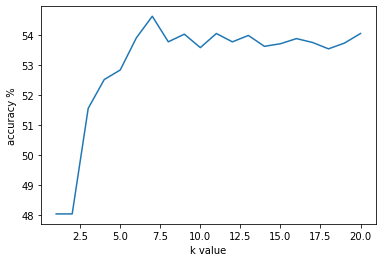

best k-value=7
with avg acc=54.617172
	 getting the distances took 38.293190 seconds?
with k=7 testing set with random_state=0 had acc=0.575758


In [10]:
#displays a plot of the accuracies v.s. the k-values
plt.xlabel('k value')
plt.ylabel('accuracy %')
plt.plot(range(1,len(store)+1),store)
plt.show()
bestIndex = store.index(max(store))
print('best k-value=%d'%(bestIndex+1))
print('with avg acc=%f'%max(store))

#like in our cross validation function the accuracy of our testing set using the best k and training set
#is calculated and displayed
testing = KNN(helper(ttrain,truetest,[1,1,1,1,1,1,1,1]), truetest, bestIndex)
acc = 0.0
for x in truetest.iterrows():
    if testing.get(x[1][0])==x[1][9]:
        acc += 1.0/len(testing)
print("with k=%d testing set with random_state=0 had acc=%f"%(1+bestIndex,acc))